# Fitting out-diffusion data with minimize: 1D mesh


**Attention:** use a kernel from a conda/mamba environment where fenicsx is installed

The fit with the numerical model is relatively slow, because time step size is constant and not (yet) optimized



In [1]:
import sys
import time
import os
import math
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
from copy import copy

Because the ADE_DG toolbox is (probably) not installed somewhere in the system we have to add the path to the location of the python code, either relative path of absolute path.

In [2]:
# import numerical toolbox ADE_DG for solving Advection-Diffusion-Equation specifically for trough-diffusion experiments
#import sys
sys.path.append("../sources") # include path to ../sources/ADE_DG1.py in path! -> this notebook is in ../notebooks/

# ADE_DG1.py must be in the path -> see path settings above
import ADE_DG
from ADE_DG import BoundaryCondition as BoundaryCondition # import BoundaryCondition in this way, otherwise it is not available ...

## Load experimental data

This example uses Magick data, specifically experiment OPC26.

In principle one can load either text files or excel spreadsheets (requires openpyxl) with data. 
Best is to have data available in SI units, all other unit systems are not fail-save!
 * **times** in (s), relative to start of experiment
 * volumetric concentrations  (mol m⁻³) or (Bq m⁻³) or (kg m⁻³) 
 * all other measurements in the same unit system!




In [3]:
%precision %.2e

# load example dataset from Magick data
# define path to data directory
data_path="../../Magick-Data/Out_diffusion_data/"
data_file_path="Test_out_diffusion_data.ods"

# Load data sets from excel file ...sheet name needs to be known...
# we have the first two rows (0 and 1) for header, take first row for name (no.0) and skip second row (no.1)
expdata=pd.read_excel(data_path+data_file_path,header=0,skiprows=[1],engine='odf')

# next commands remove trailing whitespaces from columns names
# these are a constant source of trouble, 
#because they are not visible if you print them, but are assumed part of column names
expdata.columns=expdata.columns.str.strip()
print('{:.2e}'.format(expdata.C_high[0]))
display(expdata)

1.76e-06


,time_lo,Flux_Lo,Uflux_Lo,time_hi,Flux_Hi,uFlux_Hi,time_high,C_high,C_low
0,0.543403,2.090459e-15,1.564712e-16,0.543403,3.191253e-14,2.185744e-15,0,0.000002,0
1,1.604167,1.940246e-15,1.696639e-16,1.604167,5.443891e-15,5.904309e-16,0,0.000000,0
2,2.618056,1.531586e-15,1.450976e-16,2.618056,3.264248e-15,2.910847e-16,0,0.000000,0
3,3.541667,1.517323e-15,1.460408e-16,3.541667,2.571571e-15,2.357429e-16,0,0.000000,0
4,5.562500,1.177306e-15,8.985788e-17,5.562500,1.724765e-15,1.293547e-16,0,0.000000,0
5,8.164931,8.472088e-16,8.656368e-17,8.164931,4.883169e-16,5.853376e-17,0,0.000000,0
6,10.105903,6.902175e-16,6.871729e-17,10.105903,5.164046e-16,5.273906e-17,0,0.000000,0
7,12.586806,5.824483e-16,5.014109e-17,12.586806,7.268859e-16,6.393723e-17,0,0.000000,0
8,15.046875,4.320986e-16,5.251107e-17,15.046875,5.435218e-16,6.789841e-17,0,0.000000,0
9,18.463542,3.052518e-16,2.646896e-17,18.463542,3.861600e-16,3.464921e-17,0,0.000000,0


In [4]:
# convert to correct units...in the dataset  the times are in Days! 
# (see skipped second row in excel spreadshee)
# 1Day = 1.0*24*3600
Day_to_sec=24.0*3600
expdata.time_lo=expdata.time_lo*Day_to_sec
expdata.time_hi=expdata.time_hi*Day_to_sec


In [5]:
display(expdata)


,time_lo,Flux_Lo,Uflux_Lo,time_hi,Flux_Hi,uFlux_Hi,time_high,C_high,C_low
0,46950.0,2.090459e-15,1.564712e-16,46950.0,3.191253e-14,2.185744e-15,0,0.000002,0
1,138600.0,1.940246e-15,1.696639e-16,138600.0,5.443891e-15,5.904309e-16,0,0.000000,0
2,226200.0,1.531586e-15,1.450976e-16,226200.0,3.264248e-15,2.910847e-16,0,0.000000,0
3,306000.0,1.517323e-15,1.460408e-16,306000.0,2.571571e-15,2.357429e-16,0,0.000000,0
4,480600.0,1.177306e-15,8.985788e-17,480600.0,1.724765e-15,1.293547e-16,0,0.000000,0
5,705450.0,8.472088e-16,8.656368e-17,705450.0,4.883169e-16,5.853376e-17,0,0.000000,0
6,873150.0,6.902175e-16,6.871729e-17,873150.0,5.164046e-16,5.273906e-17,0,0.000000,0
7,1087500.0,5.824483e-16,5.014109e-17,1087500.0,7.268859e-16,6.393723e-17,0,0.000000,0
8,1300050.0,4.320986e-16,5.251107e-17,1300050.0,5.435218e-16,6.789841e-17,0,0.000000,0
9,1595250.0,3.052518e-16,2.646896e-17,1595250.0,3.861600e-16,3.464921e-17,0,0.000000,0


In [6]:
#sample thickness
sample_thickness=5e-3 # unit (m) = 5 mm
cross_section_area = 0.196e-4 # unit (m²) 0.196 cm * cm
# first attempt: we start with constant reservoir volumes
upstream_volume=10.0*1e-6   # 10 ml
downstream_volume=10.0*1e-6
# boundary conditions 
upstream_concentration=0.0
downstream_concentration=0.0

# concentrations for inital conditions inside sample : NOT boundary conditions
Cu=expdata.C_high[0]
Cd=0.0

normalization_factor=expdata.C_high[0] # for normalisation!
# select only part of the dataset for fitting the breakthrough...that should increase relative weights for early times, i.e. fitting alpha
tdat=expdata.time_hi
fdat=expdata.Flux_Hi

tdatU=expdata.time_hi
fdatU=expdata.Flux_Hi
tdatD=expdata.time_lo
fdatD=expdata.Flux_Lo


t_up_rest=expdata.time_hi
t_down_rest=expdata.time_lo


In [7]:
display(Cu,normalization_factor,Cu/normalization_factor)
print(tdat,fdat)

1.76e-06

1.76e-06

1.00e+00

0       46950.0
1      138600.0
2      226200.0
3      306000.0
4      480600.0
5      705450.0
6      873150.0
7     1087500.0
8     1300050.0
9     1595250.0
10    1904400.0
11    2216700.0
12    2562300.0
Name: time_hi, dtype: float64 0     3.191253e-14
1     5.443891e-15
2     3.264248e-15
3     2.571571e-15
4     1.724765e-15
5     4.883169e-16
6     5.164046e-16
7     7.268859e-16
8     5.435218e-16
9     3.861600e-16
10    2.674433e-16
11    1.643228e-16
12    1.623935e-16
Name: Flux_Hi, dtype: float64


## Create and initialize function for numerical solver

One has to initialize and create a function that can be called from the fitting routine. 

The basic setup is based on mesh that was created with gmsh:

    * The dimensions of the mesh should be choosen that they represent the dimensions of the diffusion cell, filters, sample.
    * The different materials (sample, filter) and the influx (upstream) and outflux (downstream) boundaries have to be marked with "physical group Ids"
    * It is assumed the the upstream boundary is at x=0m and the downstream boundary at x = "lenght of sample + filters" in positive x-direction

The numerical solver is initialized via the ADE_DG call that reads the mesh from a file and requires a parameter that sets the "degree" of DG elements.

For the numerical setup the follwing parameters have to be defined and passed to the code:

    * material parameters
        - De and porosity/alpha for all materials (filter,sample)
        - Cross sectional area of the sample/filters
    * initial conditions
       - Initial concentrations everywhere in the domain
    * boundary conditions
        - position of the boundaries and their physical group id (marker no.)
        - initial concentrations in the Upstream and Downstream reservoirs
        - volume of the reservoirs
        - A flag that sets constant (boundary) concentrations in the reservoir: set_reservoir_boundaries(False), 
        or adjusts reservoir concentrations according to fluxes out of or into the reservoir: set_reservoir_boundaries(True)
        


In [22]:

# general definitions    
hour=3600.0
day=hour*24.0
year=day*365.25

# filename for gmsh file
mymesh_filename = "./gmsh/Magick1D.msh"
# define problem
# degree of desired FE is moved into ADE_DG
problem = ADE_DG.ADE_DG(mymesh_filename,deg=2)
problem.set_tol_adaptive(1.0e-12) #some default value for error tolerance used in adaptive time stepping loop
problem.set_logging_level("DEBUG")

# define everything once

# initial conditions
C0=0.0 # initial condition

# effective Diffusion for all marked materials
# we introduce default values
# markers can be found in gmsh geo file
De=1.0e-11
De_dict={
    5 : 1.0e-11,   #sample
}

# porosity/alpha ..this are default values
alpha=0.1
porosity_dict={
    5 : alpha    #sample
}
# if diffusion only the Darcy flux is 0.0 (zero) for all components
darcy_flux_vector = (0.0,0.0) # list  will work ...

# initial condition
problem.set_initial_conditions_out_diffusion(Cu/normalization_factor,Cd/normalization_factor,0.0,0.005) # upstream concentration, downstream concentration, x-upstream boundary, x downstream boundary

problem.set_darcy_flux(darcy_flux_vector)
problem.set_De(De_dict)
problem.set_porosity(porosity_dict)
# write materials in specific vtx file (do not use the same file as for time steps. this will overwrite file=
#problem.vtx_write_materials(filename_vtx_materials,t=0.0) 
problem.set_upstream_boundary(3,0.0) # should be "left boundary"
problem.set_upstream_reservoir_concentration(upstream_concentration) # will be overwritten in flux_model function
problem.set_upstream_reservoir_volume(upstream_volume)

problem.set_downstream_boundary(4,0.005) # should be "right  boundary"
problem.set_downstream_reservoir_concentration(0.0) # will be overwritten in flux_model function
problem.set_downstream_reservoir_volume(downstream_volume)

problem.set_update_reservoir_boundaries(True) # if up-stream and down-stream reservoirs should be defined ..needs defintion of reservoir properties
problem.set_downstream_reservoir_exchange_solution_times(t_down_rest,rflag=True) # rflag: see documentation! rflag indicates if reservoirs are set to zero concentration at the times in t_down_rest (experimental exchange of solution)
problem.set_upstream_reservoir_exchange_solution_times(t_up_rest,rflag=True)

problem.set_cross_section_area(cross_section_area) # 1 for comparison with analytical solution
problem.set_tol_adaptive(1.0e-5) # tolerance for adaptive time stepping

problem.set_logging_enabled() # enable logging
problem.set_logging_level("INFO")

#problem.set_logging_disabled() # disable

INFO:root:INFO: init with: ./gmsh/Magick1D.msh deg 2
INFO:root:INFO: mesh read! mesh dimension: 1 boundary dimension 0 geometry dimension: 2
INFO:root:Darcy flux is set to: (0.0, 0.0) for the whole domain.
INFO:root:INFO: De set via dictionary {5: 1e-11} default: 1.0e-11 
INFO:root:porosity set via dictionary {5: 0.1} default: 1.0
DEBUG:root:DEBUG: self.__downstream_exchange_times_done[False False False False False False False False False False False False
 False]
DEBUG:root:DEBUG: self.__upstream_exchange_times_done[False False False False False False False False False False False False
 False]


Info    : Reading './gmsh/Magick1D.msh'...
Info    : 3 entities
Info    : 18 nodes
Info    : 19 elements
Info    : Done reading './gmsh/Magick1D.msh'
set logging to level:  DEBUG
set logging to level:  INFO


## One manual run to test parameters

Before one does possibly time consuming fitting, it makes sense to once run the model to check input parameters and if the model runs at all.



In [9]:
# see here https://stackoverflow.com/questions/77047232/python-and-lmfit-fit-multiple-data-sets-with-different-lengths

def flux_model(problem=problem,alpha=alpha,De=De):

    #### definitions for ADE-DG solutions that need to be re-set for multiple runs
    # only reset everything that is changed during simulations or due to call -> alpha

    # porosity
    porosity_dict={
        5 : alpha  #sample   
    }
    # De
    De_dict={
        5 : De   #sample
    }

    
    problem.set_porosity(porosity_dict)
    problem.set_De(De_dict)

    #problem.set_update_reservoir_boundaries(False) # if up-stream and down-stream reservoirs should be defined ..needs defintion of reservoir properties
    problem.set_upstream_boundary(3,0.0) # should be "left boundary"
    problem.set_downstream_boundary(4,0.005) # should be "right  boundary"
#
    problem.set_downstream_reservoir_exchange_solution_times(t_down_rest,rflag=True)
    problem.set_upstream_reservoir_exchange_solution_times(t_up_rest,rflag=True)
    
    problem.set_upstream_reservoir_concentration(upstream_concentration/normalization_factor) 
    problem.set_downstream_reservoir_concentration(downstream_concentration/normalization_factor)

    u0=problem.set_initial_conditions_out_diffusion(concu=Cu/normalization_factor,concl=Cd/normalization_factor,xu=0.0,xl=0.005) # upstream concentration, downstream concentration, x-upstream boundary, x downstream boundary
    display(u0.x.array[:])
    # Time stepping
    t_end=max(tdat)
    dt=1000.0
    problem.set_dt(dt)
    problem.set_T_end(t_end)

    solution,moddata=problem.solve_adaptive_timesteps()
    solution.x.array[:]=solution.x.array[:]*normalization_factor
    moddata.iloc[0:,2:]=moddata.iloc[:,2:]* normalization_factor

    return moddata    

In [10]:
problem.set_logging_level("INFO") # do not set to info, otherwise to much information is shown
# we can set number of time steppings via adaptive tolerance

problem.set_tol_adaptive(1.0e-6) # same value as for manual test
De =5e-12
alpha =1.6
# for time interpolation we can use np.interpolate

moddata=flux_model(problem,alpha,De)

INFO:root:porosity set via dictionary {5: 1.6} default: 1.0
INFO:root:INFO: De set via dictionary {5: 5e-12} default: 1.0e-11 


set logging to level:  INFO


array([0.        , 0.05882353, 0.02941176, 0.05882353, 0.11764706,
       0.08823529, 0.11764706, 0.17647059, 0.14705882, 0.17647059,
       0.23529412, 0.20588235, 0.23529412, 0.29411765, 0.26470588,
       0.29411765, 0.35294118, 0.32352941, 0.35294118, 0.41176471,
       0.38235294, 0.41176471, 0.47058824, 0.44117647, 0.47058824,
       0.52941176, 0.5       , 0.52941176, 0.58823529, 0.55882353,
       0.58823529, 0.64705882, 0.61764706, 0.64705882, 0.70588235,
       0.67647059, 0.70588235, 0.76470588, 0.73529412, 0.76470588,
       0.82352941, 0.79411765, 0.82352941, 0.88235294, 0.85294118,
       0.88235294, 0.94117647, 0.91176471, 0.94117647, 1.        ,
       0.97058824])

INFO:root:INFO: Adaptive time loop starts with error tolerance: 1e-06 update_reservoir_concentrations: True
INFO:root:INFO: t dt error est     0.0000 |     1.3040 |  9.513e-07
INFO:root:INFO: t dt error est     1.3040 |     1.2683 |  1.132e-12
INFO:root:INFO: t dt error est     2.5723 |    87.1293 |  3.063e-07
INFO:root:INFO: t dt error est    89.7016 |   132.8100 |  8.256e-07
INFO:root:INFO: t dt error est   222.5116 |   138.6651 |  7.059e-07
INFO:root:INFO: t dt error est   361.1767 |   156.5712 |  7.442e-07
INFO:root:INFO: t dt error est   517.7478 |   172.1860 |  7.105e-07
INFO:root:INFO: t dt error est   689.9339 |   193.7933 |  7.097e-07
INFO:root:INFO: t dt error est   883.7272 |   218.2405 |  6.942e-07
INFO:root:INFO: t dt error est  1101.9676 |   248.5015 |  6.866e-07
INFO:root:INFO: t dt error est  1350.4691 |   284.5206 |  6.777e-07
INFO:root:INFO: t dt error est  1634.9897 |   327.8834 |  6.727e-07
INFO:root:INFO: t dt error est  1962.8732 |   379.2517 |  6.697e-07
INFO:roo

In [11]:
print(moddata)

              time             dt  Upstream_concentration  \
row1  0.000000e+00       1.303995            3.015146e-13   
row1  1.303995e+00       1.268337            5.945981e-13   
row1  2.572332e+00      87.129257            1.989357e-11   
row1  8.970159e+01     132.810013            4.759748e-11   
row1  2.225116e+02     138.665062            7.490836e-11   
...            ...            ...                     ...   
row1  1.869982e+06   34418.031380            2.295146e-10   
row1  1.904400e+06  141721.738154            7.855651e-11   
row1  2.046122e+06  170578.261846            1.551319e-10   
row1  2.216700e+06  193444.011796            6.837447e-11   
row1  2.410144e+06  152155.988204            1.129422e-10   

      Downstream_concentration  Upstream_flux  Downstream_flux  
row1              4.502423e-15  -1.179713e-13    -1.761628e-15  
row1              8.881726e-15  -1.178964e-13    -1.761628e-15  
row1              3.097209e-13  -1.130093e-13    -1.761628e-15  
row1   

In [12]:

display(moddata)
downflux=np.interp(tdat, moddata.time, np.abs(moddata.Downstream_flux))
upflux=np.interp(tdat, moddata.time, np.abs(moddata.Upstream_flux))



,time,dt,Upstream_concentration,Downstream_concentration,Upstream_flux,Downstream_flux
row1,0.000000e+00,1.303995,3.015146e-13,4.502423e-15,-1.179713e-13,-1.761628e-15
row1,1.303995e+00,1.268337,5.945981e-13,8.881726e-15,-1.178964e-13,-1.761628e-15
row1,2.572332e+00,87.129257,1.989357e-11,3.097209e-13,-1.130093e-13,-1.761628e-15
row1,8.970159e+01,132.810013,4.759748e-11,7.682861e-13,-1.064276e-13,-1.761628e-15
row1,2.225116e+02,138.665062,7.490836e-11,1.247068e-12,-1.004876e-13,-1.761628e-15
...,...,...,...,...,...,...
row1,1.869982e+06,34418.031380,2.295146e-10,2.289320e-10,-3.369932e-16,-3.364285e-16
row1,1.904400e+06,141721.738154,7.855651e-11,7.847913e-11,-2.828067e-16,-2.825281e-16
row1,2.046122e+06,170578.261846,1.551319e-10,1.550149e-10,-2.290391e-16,-2.289206e-16
row1,2.216700e+06,193444.011796,6.837447e-11,6.835750e-11,-1.803361e-16,-1.802913e-16


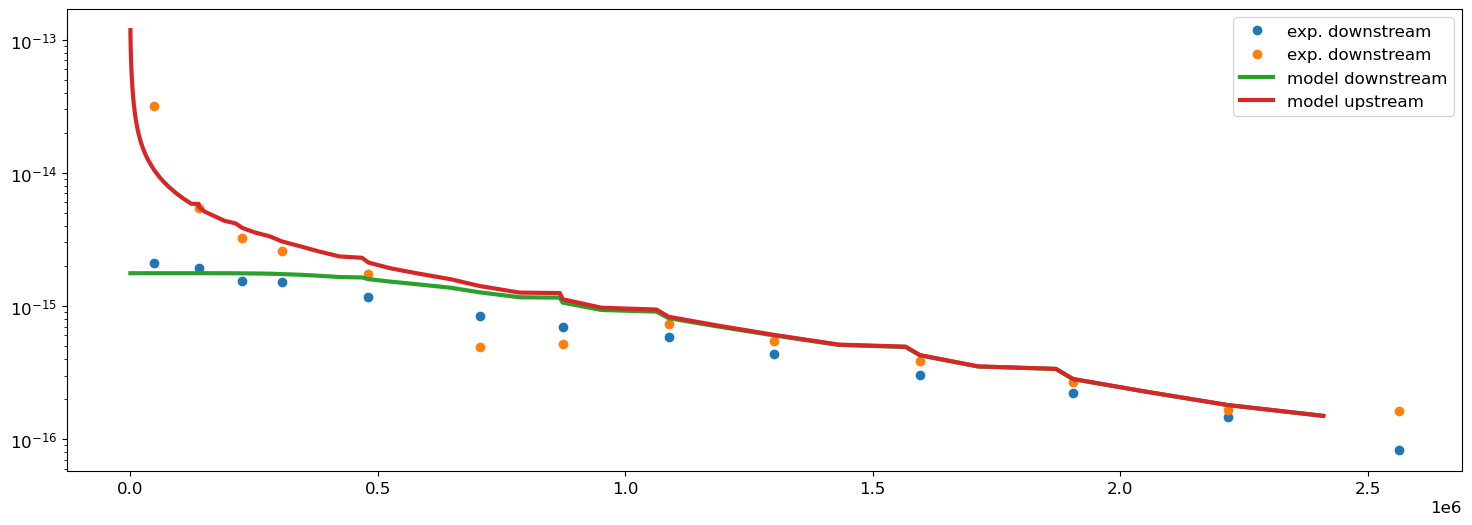

In [13]:
# firs we plot the fluxes ...aka breakthrough

plt.rcParams["figure.figsize"] = [18, 6]

plt.rcParams.update({'lines.linewidth':3}) # plt parameters are used also for next plots! -> change again if necessary
#display(fluxes)

plt.rcParams.update({'font.size': 12}) # update font size..default is 10 !

#plt.plot(tdat, fdat, 'o')
#plt.plot(tdat, result_analytic.init_fit, '--', label='initial fit')
plt.plot(expdata.time_lo,expdata.Flux_Lo,'o',label='exp. downstream')
plt.plot(expdata.time_hi,expdata.Flux_Hi,'o',label='exp. downstream')

plt.plot(moddata.time, -1.0*(moddata.Downstream_flux), '-', label='model downstream')
plt.plot(moddata.time, -1.0*(moddata.Upstream_flux), '-', label='model upstream')
#plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

## Fitting with LMFIT

https://lmfit.github.io/lmfit-py/intro.html

The lmfit package provides simple tools to help you build complex fitting models for non-linear least-squares problems and apply these models to real data.

**Install lmfit-py with** **"mamba install lmfit"**

Why use lmfit?

While scipy offers an standard approach to optimization and curve fitting, LMFIT is a specialised tool that offers better support for advanced methods and diagnostic tools!


In [14]:

import lmfit as lmfit

#params = lmfit.Parameters()
#params.add('alpha', 0.6) # starting value for fit
#params.add('De', value=3.0e-12) # starting value for fit


In [15]:
# see here https://stackoverflow.com/questions/77047232/python-and-lmfit-fit-multiple-data-sets-with-different-lengths

def objective(params,tdatU,fdatU,tdatD,fdatD):
    alpha = params['alpha']
    De = params['De']


    # this can be moved out of the loop , at least in principle
    #problem.set_update_reservoir_boundaries(False) # if up-stream and down-stream reservoirs should be defined ..needs defintion of reservoir properties
    problem.set_upstream_boundary(3,0.0) # should be "left boundary"
    problem.set_downstream_boundary(4,0.005) # should be "right  boundary"
#    problem.set_tol_adaptive(1.0e-8)  
    #### definitions for ADE-DG solutions that need to be re-set for multiple runs
    # only reset everything that is changed during simulations or due to call -> alpha
    C0=0.0 # initial concentration 
    
    # porosity
    porosity_dict={
        5 : alpha  #sample   
    }
    # De
    De_dict={
        5 : De   #sample
    }
    u_old=problem.set_initial_conditions_out_diffusion(Cu/normalization_factor,Cd/normalization_factor,0.0,0.005) # upstream concentration, downstream concentration, x-upstream boundary, x downstream boundary
    
    problem.set_porosity(porosity_dict)
    problem.set_De(De_dict)
    
    problem.set_downstream_reservoir_exchange_solution_times(t_down_rest)
    problem.set_upstream_reservoir_exchange_solution_times(t_up_rest)
    
    problem.set_upstream_reservoir_concentration(upstream_concentration/normalization_factor) 
    problem.set_downstream_reservoir_concentration(downstream_concentration/normalization_factor)
    
    # Time stepping
    t_end=max(tdat)
    dt=1000.0
    problem.set_dt(dt)
    problem.set_T_end(t_end)

    solution,data=problem.solve_adaptive_timesteps()
    solution.x.array[:]=solution.x.array[:]*normalization_factor
    data.iloc[0:,2:]=data.iloc[:,2:]* normalization_factor
    #solution,data=problem.solve_timesteps() # fixed time stepping scheme! solution is fenics Function(V) object, while data is a pandas data frame
    # add integrates downstream fluxes for fitting
    #data['Downstream_flux_integr']=sc.integrate.cumulative_trapezoid(data.Downstream_flux,data.time,initial=0.0) # fluxes and concentrations need to be scaled back if used directly...

    ################## residual for fluxes ######################
    # for weighting we use the 1/variance !
    #weight_flux=1.0/(fdatU*fdatU)
    # for time interpolation we can use np.interpolate
    fluxD=np.interp(tdatD, data.time, np.abs(data.Downstream_flux))
    fluxU=np.interp(tdatU, data.time, np.abs(data.Upstream_flux))
    
    # resdiual fluxes are differences in y-values
    ########### fit log values!!!!!!)
    fluxD_res=(np.log(fdatD)-np.log(fluxD))
    fluxU_res=(np.log(fdatU)-np.log(fluxU))
    ################### residual for concentrations ##############
    # for weighting we use the 1/variance !
    #weight_uconc=1.0/(cudatU*cudatU)
    #uconc=np.interp(tudat,data.time,data.Upstream_concentration)
    #uconc_res=(cudat-uconc)*weight_uconc
    # for time interpolation we can use np.interpolate
#    concentration=np.interp(tudat, data.time, np.abs(data.Upstream_concentration))
#    uconc_res=(cudat-concentration)
# for fitting integrated data!
#    flux=np.interp(tdat, data.time, np.abs(data.Downstream_flux_integr)) 

    #print("objective: called with alpha,De,residual "+str(np.sum(flux_res))+str(alpha)+str(De))
    #print("Debug: solution, data, flux ",solution,data,flux)
    return np.concatenate((fluxD_res,fluxU_res)) 
#    return fluxU_res

 

In [16]:
problem.set_logging_level("ERROR") # do not set to info, otherwise to much information is shown
# we can set number of time steppings via adaptive tolerance
#problem.set_update_reservoir_boundaries(False)
problem.set_tol_adaptive(1.0e-6) # same value as for manual test

#problem.set_logging_disabled() # disable

params = lmfit.Parameters()
params.add('De', value=2.0e-12, min=1.0e-14, max=2.0e-9)
params.add('alpha', value=0.2, min=0.1, max=10.0)

#method = 'leastsq'

# create Minimizer
#mini = lmfit.Minimizer(objective, params, fcn_args=(tdatU,fdatU,tdatD,fdatD), nan_policy='propagate')
mini = lmfit.Minimizer(objective, params, fcn_args=(tdatU,fdatU,tdatD,fdatD), nan_policy='propagate')
print('####################### fit with Minimizer object for custom resdidual function  ###########################')
# first solve with Nelder-Mead algorithm
result_ademodel= mini.minimize(method='leastsq')


#result_ademodel = lmfit.minimize(objective, params, args=(tdat, fdat), method=method)
print("# Fit using sum of squares:\n")
lmfit.report_fit(result_ademodel)

set logging to level:  ERROR
####################### fit with Minimizer object for custom resdidual function  ###########################
# Fit using sum of squares:

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 26
    # variables        = 2
    chi-square         = 3.36984404
    reduced chi-square = 0.14041017
    Akaike info crit   = -49.1239819
    Bayesian info crit = -46.6077888
[[Variables]]
    De:     4.4705e-12 +/- 5.6166e-13 (12.56%) (init = 2e-12)
    alpha:  1.35658200 +/- 0.10897164 (8.03%) (init = 0.2)
[[Correlations]] (unreported correlations are < 0.100)
    C(De, alpha) = +0.8625


In [17]:
# run the model again

problem.set_logging_level("ERROR") # do not set to info, otherwise to much information is shown
# we can set number of time steppings via adaptive tolerance
#problem.set_update_reservoir_boundaries(False)
problem.set_tol_adaptive(1.0e-6) # same value as for manual test
#### definitions for ADE-DG solutions that need to be re-set for multiple runs

De=result_ademodel.params['De']
alpha=result_ademodel.params['alpha']

dummy=np.array(result_ademodel.params) # best fit parameters
display((result_ademodel.params))
DeU=result_ademodel.params['De']
print(DeU)
alphaU=result_ademodel.params['alpha']
print(alphaU.stderr)

set logging to level:  ERROR


name,value,standard error,relative error,initial value,min,max,vary
De,4.4705e-12,5.6166e-13,(12.56%),2e-12,1.0000e-14,2.0000e-09,True
alpha,1.35658200,0.10897164,(8.03%),0.2,0.10000000,10.0000000,True


<Parameter 'De', value=np.float64(4.470507064294467e-12) +/- 5.62e-13, bounds=[1e-14:2e-09]>
0.10897164191109925


In [18]:

# for time interpolation we can use np.interpolate

flux=flux_model(problem,alpha,De)
# for time interpolation we can use np.interpolate
#flux=flux_model(problem=problem, alpha=alpha,De=De)

# simple way to get some uncertainity bands to the plot:
# we do it for +-2 sigma
# take the results of confi and run bounding cases with De_max, De_min, alpha_max, alpha_min


dummy=flux_model(problem, alphaU.value+2*alphaU.stderr,DeU.value+2*DeU.stderr)
flux1=np.interp(tdat, dummy.time, np.abs(dummy.Upstream_flux))

dummy=flux_model(problem, alphaU.value+2*alphaU.stderr,DeU.value-2*DeU.stderr)
flux2=np.interp(tdat, dummy.time, np.abs(dummy.Upstream_flux))

dummy=flux_model(problem, alphaU.value-2*alphaU.stderr,DeU.value+2*DeU.stderr)
flux3=np.interp(tdat, dummy.time, np.abs(dummy.Upstream_flux))

dummy=flux_model(problem, alphaU.value-2*alphaU.stderr,DeU.value-2*DeU.stderr)
flux4=np.interp(tdat, dummy.time, np.abs(dummy.Upstream_flux))

#some more postprocessing is required....
flux_max=np.maximum.reduce([flux1,flux2,flux3,flux4])
flux_min=np.minimum.reduce([flux1,flux2,flux3,flux4])

array([0.        , 0.05882353, 0.02941176, 0.05882353, 0.11764706,
       0.08823529, 0.11764706, 0.17647059, 0.14705882, 0.17647059,
       0.23529412, 0.20588235, 0.23529412, 0.29411765, 0.26470588,
       0.29411765, 0.35294118, 0.32352941, 0.35294118, 0.41176471,
       0.38235294, 0.41176471, 0.47058824, 0.44117647, 0.47058824,
       0.52941176, 0.5       , 0.52941176, 0.58823529, 0.55882353,
       0.58823529, 0.64705882, 0.61764706, 0.64705882, 0.70588235,
       0.67647059, 0.70588235, 0.76470588, 0.73529412, 0.76470588,
       0.82352941, 0.79411765, 0.82352941, 0.88235294, 0.85294118,
       0.88235294, 0.94117647, 0.91176471, 0.94117647, 1.        ,
       0.97058824])

array([0.        , 0.05882353, 0.02941176, 0.05882353, 0.11764706,
       0.08823529, 0.11764706, 0.17647059, 0.14705882, 0.17647059,
       0.23529412, 0.20588235, 0.23529412, 0.29411765, 0.26470588,
       0.29411765, 0.35294118, 0.32352941, 0.35294118, 0.41176471,
       0.38235294, 0.41176471, 0.47058824, 0.44117647, 0.47058824,
       0.52941176, 0.5       , 0.52941176, 0.58823529, 0.55882353,
       0.58823529, 0.64705882, 0.61764706, 0.64705882, 0.70588235,
       0.67647059, 0.70588235, 0.76470588, 0.73529412, 0.76470588,
       0.82352941, 0.79411765, 0.82352941, 0.88235294, 0.85294118,
       0.88235294, 0.94117647, 0.91176471, 0.94117647, 1.        ,
       0.97058824])

array([0.        , 0.05882353, 0.02941176, 0.05882353, 0.11764706,
       0.08823529, 0.11764706, 0.17647059, 0.14705882, 0.17647059,
       0.23529412, 0.20588235, 0.23529412, 0.29411765, 0.26470588,
       0.29411765, 0.35294118, 0.32352941, 0.35294118, 0.41176471,
       0.38235294, 0.41176471, 0.47058824, 0.44117647, 0.47058824,
       0.52941176, 0.5       , 0.52941176, 0.58823529, 0.55882353,
       0.58823529, 0.64705882, 0.61764706, 0.64705882, 0.70588235,
       0.67647059, 0.70588235, 0.76470588, 0.73529412, 0.76470588,
       0.82352941, 0.79411765, 0.82352941, 0.88235294, 0.85294118,
       0.88235294, 0.94117647, 0.91176471, 0.94117647, 1.        ,
       0.97058824])

array([0.        , 0.05882353, 0.02941176, 0.05882353, 0.11764706,
       0.08823529, 0.11764706, 0.17647059, 0.14705882, 0.17647059,
       0.23529412, 0.20588235, 0.23529412, 0.29411765, 0.26470588,
       0.29411765, 0.35294118, 0.32352941, 0.35294118, 0.41176471,
       0.38235294, 0.41176471, 0.47058824, 0.44117647, 0.47058824,
       0.52941176, 0.5       , 0.52941176, 0.58823529, 0.55882353,
       0.58823529, 0.64705882, 0.61764706, 0.64705882, 0.70588235,
       0.67647059, 0.70588235, 0.76470588, 0.73529412, 0.76470588,
       0.82352941, 0.79411765, 0.82352941, 0.88235294, 0.85294118,
       0.88235294, 0.94117647, 0.91176471, 0.94117647, 1.        ,
       0.97058824])

array([0.        , 0.05882353, 0.02941176, 0.05882353, 0.11764706,
       0.08823529, 0.11764706, 0.17647059, 0.14705882, 0.17647059,
       0.23529412, 0.20588235, 0.23529412, 0.29411765, 0.26470588,
       0.29411765, 0.35294118, 0.32352941, 0.35294118, 0.41176471,
       0.38235294, 0.41176471, 0.47058824, 0.44117647, 0.47058824,
       0.52941176, 0.5       , 0.52941176, 0.58823529, 0.55882353,
       0.58823529, 0.64705882, 0.61764706, 0.64705882, 0.70588235,
       0.67647059, 0.70588235, 0.76470588, 0.73529412, 0.76470588,
       0.82352941, 0.79411765, 0.82352941, 0.88235294, 0.85294118,
       0.88235294, 0.94117647, 0.91176471, 0.94117647, 1.        ,
       0.97058824])

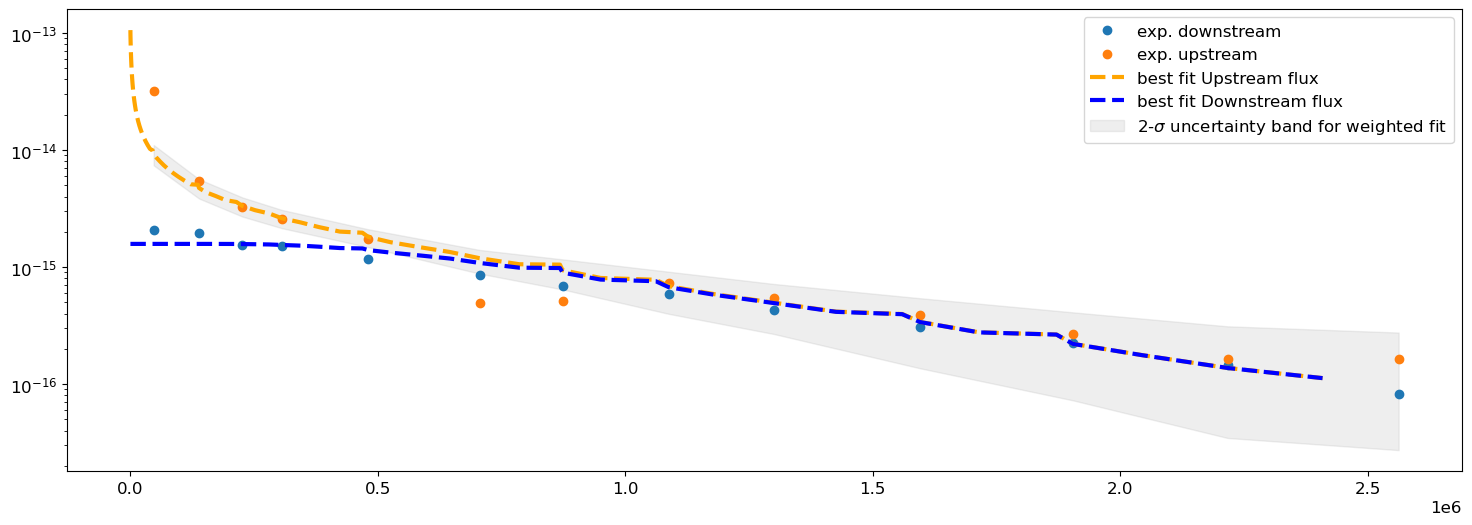

In [21]:
# firs we plot the fluxes ...aka breakthrough
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [18, 6]

plt.rcParams.update({'lines.linewidth':3}) # plt parameters are used also for next plots! -> change again if necessary
#display(fluxes)

plt.rcParams.update({'font.size': 12}) # update font size..default is 10 !

plt.plot(expdata.time_lo,(expdata.Flux_Lo),'o',label='exp. downstream')
plt.plot(expdata.time_hi,(expdata.Flux_Hi),'o',label='exp. upstream')
#plt.plot(tdat, result_analytic.init_fit, '--', label='initial fit')

#plt.fill_between(tdat, result_ademodel.best_fit-dely, result_ademodel.best_fit+dely, color="#ABABAB",
plt.plot(flux.time, -1.0*flux.Upstream_flux, '--', label='best fit Upstream flux', color='orange')
plt.plot(flux.time, -1.0*flux.Downstream_flux, '--', label='best fit Downstream flux', color='blue')

plt.fill_between(tdat, flux_min, flux_max, color="#ABABAB",
                 label=r'2-$\sigma$ uncertainty band for weighted fit',alpha=0.2)

#plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.show()

In [20]:
lmfit.report_ci(confi)
mtest=confi['De']
print(mtest[1][1])
print(mtest[5][1])

#plt.fill_between(x, result.best_fit-dely, result.best_fit+dely, color="#ABABAB",
#                 label=r'3-$\sigma$ uncertainty band')

NameError: name 'confi' is not defined

In [ ]:
result_ademodel.best_fit

In [ ]:
# only reset everything that is changed during simulations or due to call -> alpha
DeU=confi['De']
print(DeU[1][1])
print(DeU[5][1])
alphaU=confi['alpha']

De = DeU[3][1] #dummy[0]
alpha =alphaU[3][1] #dummy[1]

DeU=confi['De']
print(DeU[1][1])
print(DeU[5][1])
alphaU=confi['alpha']